In [1]:
import os
import sys
from os.path import join, exists, basename, dirname
import glob

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = join(gwfm_dir, 'Oneto_Denier')
dat_dir = join(proj_dir,'Stream_level_data')
map_dir = join(gwfm_dir,'Mapping')

sfr_dir = join(gwfm_dir,'SFR_data')
hob_dir = join(gwfm_dir,'HOB_data')
uzf_dir = join(gwfm_dir, 'UZF_data')


In [3]:
out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [4]:
from importlib import reload
def add_path(fxn_dir):
    if fxn_dir not in sys.path:
        sys.path.append(fxn_dir)
        
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)

import flopy 
import flopy.utils.binaryfile as bf


add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities')
add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities')

In [5]:
from map_cln import gdf_bnds, pnt_2_tup, lab_pnt, plt_cln
from mf_utility import get_dates, get_layer_from_elev, clean_wb

In [6]:
# import mf_utility
# reload(mf_utility)

In [7]:
grid_r = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


In [8]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'

In [9]:
grid_match = gpd.sjoin(grid_p, grid_r, how='left',lsuffix='c',rsuffix='p')
grid_match = grid_match.rename(columns={'node_c':'node','row_c':'row','column_c':'column'})

In [10]:
grid_p['id'] = 0
m_domain = grid_p.dissolve('id')

In [11]:
# get exterior polyline of model grid
grid_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union.exterior], crs=grid_p.crs)
# find cells that construct the model boundary
bnd_cells = gpd.sjoin(grid_p, grid_bnd)
# bnd_cells = bnd_cells[['row','column']] - 1
# bnd_cells['grid_id'] = np.arange(0,len(bnd_cells))
# bnd_rows, bnd_cols = bnd_cells.row.values, bnd_cells.column.values

In [12]:
rivers = gpd.read_file(join(sfr_dir,"Sac_valley_rivers/Sac_valley_rivers.shp"))
rivers = rivers.to_crs('EPSG:32610')

mb_regional = gpd.read_file(join(gwfm_dir,"DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"))
# mb = gpd.read_file(join(gwfm_dir,"DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"))
rivers_clip = gpd.clip(rivers, mb_regional)

soam = gpd.read_file(join(map_dir,"so_am_subbasin/so_am_subbasin.shp"))
soam = soam.to_crs('EPSG:32610')
cos = gpd.read_file(join(map_dir,"cos_subbasin/cos_subbasin.shp"))
cos = cos.to_crs('EPSG:32610')

ca = gpd.read_file(join(map_dir,"ca_state_boundary/CA_State_TIGER2016.shp"))
ca = ca.to_crs('EPSG:32610')

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [13]:
cr = rivers_clip[rivers_clip.GNIS_Name=='Cosumnes River']
mr = rivers_clip[rivers_clip.GNIS_Name=='Mokelumne River']

In [14]:
prms_gis = join(gwfm_dir,'PRMS','GIS')
ws_gdf = gpd.read_file(join(prms_gis, "NHD_H_18040013_HU8_Shape\Shape\WBDHU8.shp"))
ws_gdf=ws_gdf.to_crs(m_domain.crs)

<>:2: DeprecationWarning: invalid escape sequence '\S'
<>:2: DeprecationWarning: invalid escape sequence '\S'
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_16640\141272345.py:2: DeprecationWarning: invalid escape sequence '\S'
  ws_gdf = gpd.read_file(join(prms_gis, "NHD_H_18040013_HU8_Shape\Shape\WBDHU8.shp"))


In [15]:
df = pd.read_csv(join(hob_dir,'CosumnesRiverPreserve_MW_screened_interval.csv'))
rm_sp = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude,df.Latitude), crs='epsg:4326')
rm_sp = rm_sp.to_crs('epsg:32610')
rm_sp = rm_sp.rename(columns={'Well ID':'Sensor'})

# prepare output for modelgrid join
rm_t = rm_sp[rm_sp['At Oneto-Denier']=='Yes']


In [16]:
levee_removal = gpd.read_file(join(map_dir, 'levee_removal_OD','levee_removal_OD.shp'))

In [17]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
# ifp = gpd.read_file(join(lak_shp,'inner_floodplain_domain/inner_floodplain_domain.shp' )).to_crs('epsg:32610')
# lfp = gpd.read_file(join(lak_shp,'lower_floodplain_approximate_area/lower_floodplain_approximate_area.shp' )).to_crs('epsg:32610')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')

fp_logger = pd.read_csv(join(gwfm_dir,'LAK_data','floodplain_logger_metadata.csv'))
fp_logger = gpd.GeoDataFrame(fp_logger, geometry = gpd.points_from_xy(fp_logger.Easting, fp_logger.Northing), crs='epsg:32610')
# find grid cell it is within
# fp_grid = gpd.sjoin(fp_logger, grid_p, how='left',op='within')

In [18]:
od_breach = fp_logger[fp_logger['Logger Location']=='OD_Excavation']
od_swale = fp_logger[fp_logger['Logger Location']=='SwaleBreach_1']

In [19]:


legend_elements = [
    Patch(facecolor='none', edgecolor='black', linestyle = '--', alpha=1., label='Watershed Extent'),
    Patch(facecolor='none', edgecolor='black',alpha=1., label='Model Extent'),
    Patch(facecolor='none', edgecolor='red',alpha=1., label='Levee removal and\nexcavation areas'),
    Patch(facecolor='tab:blue', alpha=0.5, label='Reconnected Floodplain'),
    Line2D([0], [0],color='tab:blue',label='Cosumnes River'),
    Line2D([0], [0], marker='.', linestyle='', color='blue', label='Monitoring Well'),
]



(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x20addc86050>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x20addcf0730>)

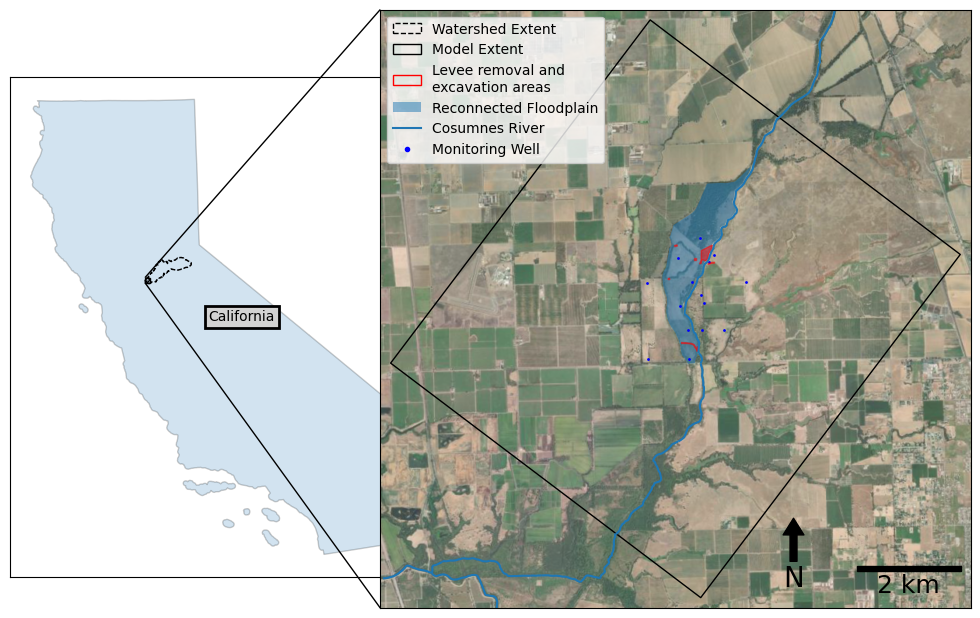

In [20]:
fig, axins =plt.subplots(figsize=(6.5,6.5))

# second one is smaller inset
axins.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)

ca.plot(ax = axins,alpha = 0.2, edgecolor='black')
axins.annotate(text='California', xy=lab_pnt(ca), 
            xytext = (6,6), textcoords = 'offset pixels',
            bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=2))
# soam.plot(ax = axins, edgecolor = 'black')
# cos.plot(ax = axins, edgecolor = 'black')
ws_gdf.plot(color='none',ax=axins, linestyle='--')
m_domain.plot(color="none",edgecolor='black',ax=axins)


# first one is CA map
ax = inset_axes(axins, width="100%", height="100%", bbox_to_anchor=(0.8, -.1, 1.3, 1.3),
                  bbox_transform=axins.transAxes, loc=2)
ax.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)

plt_bnds = gdf_bnds(m_domain,ax=ax, buf=200)
# plt_bnds.plot(ax=axins, color='none')

# od_breach.plot(ax=ax)
# od_swale.plot(ax=ax)

m_domain.plot(color="none",edgecolor='black',ax=ax)

cr.plot(ax=ax, color='tab:blue')
mr.plot(ax=ax, color='tab:blue')

lak_extent.plot(ax=ax, color='tab:blue',  alpha=0.5)
rm_t.plot(legend=False,ax=ax, color='blue', markersize=1)
levee_removal.plot(ax=ax, color='red', edgecolor='red', alpha=0.5)
ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                crs = 'epsg:26910', alpha=0.8)

x, y, arrow_length = 0.7, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, 
            xycoords=ax.transAxes)

fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           2000, '2 km', 'lower right', pad=0.3, sep=2,color='black',
                           frameon=False, size_vertical=1E2, fontproperties=fontprops)
ax.add_artist(scalebar)

ax.legend(handles=legend_elements, loc='upper left')

mark_inset(axins, ax, loc1=2, loc2=3, fc="none", ec="black")


# Model summary plots
It would be cool to have functions that are built on using the flopy output rather than using input data even slightly slower because then there is more interoperability

In [22]:
loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/'
model_nam = 'oneto_denier_upscale4x_2014_2018/'

# loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/'
# model_nam = 'oneto_denier_upscale4x_2014_2020_no_reconnection/'

model_ws = loadpth+model_nam
model_ws

'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/oneto_denier_upscale4x_2014_2018/'

In [23]:
m = flopy.modflow.Modflow.load(f = 'MF.nam',  model_ws = model_ws)

In [24]:
dis = m.dis

In [25]:
tmuni = ['s','m','h','D','M','Y'][m.dis.itmuni-1]
tr = ~m.dis.steady.array
delr = m.dis.delr[0]
delc = m.dis.delc[0]


In [26]:
strt_date, end_date, dt_ref = get_dates(m.dis, ref='strt')


### Hydrologic input plots (methods)

In [27]:
sfr_dir = join(gwfm_dir, 'SFR_data')
# USGS presents flow in cfs (cubic feet per second)
inflow_in = pd.read_csv(join(sfr_dir,'MB_daily_flow_cfs_2010_2019.csv'), index_col = 'datetime', parse_dates = True)

# covnert flow from cubic feet per second to cubic meters per day
inflow_in['flow_cms'] = inflow_in.flow_cfs * (1/(3.28**3))
# filter out data between the stress period dates
inflow = inflow_in.loc[strt_date:end_date]

In [29]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'CIMIS', 'Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000
# subset to model and reindex to match streamflow dates
rain_plt = rain_m['Fair Oaks'].loc[strt_date:end_date]
rain_plt = rain_plt.reindex(inflow.index)

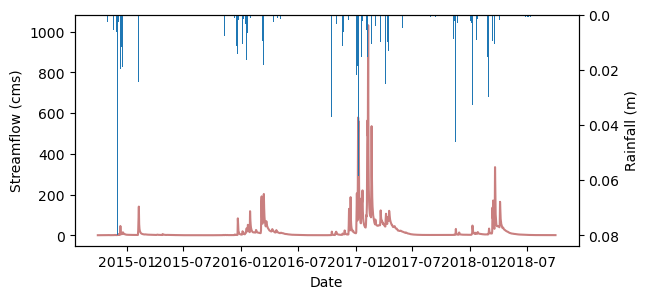

In [30]:
fig, ax = plt.subplots(figsize=(6.5,3))

dt = inflow.index.values
ax.plot(dt, inflow['flow_cms'], color='brown', alpha=0.6)
# Create second axes, in order to get the bars from the top you can multiply by -1
ax2 = ax.twinx()
ax2.bar(dt, -rain_plt, 0.9)
# Now need to fix the axis labels
max_pre = np.max(rain_plt)+0.01
y2_ticks = np.arange(0, max_pre, 0.02)
y2_ticklabels = [str(i) for i in y2_ticks]
ax2.set_yticks(-1 * y2_ticks)
ax2.set_yticklabels(y2_ticklabels)

ax2.set_ylabel('Rainfall (m)')
ax.set_ylabel('Streamflow (cms)')
ax.ticklabel_format(style='plain', axis='y') 
ax.set_xlabel('Date')

plt.show()


#### Identify general hydrologic characteristics

In [31]:
print('Days above 23 cms:',(inflow.flow_cms>23).sum())
(inflow.flow_cms>23).resample('AS-Oct').sum()

Days above 23 cms: 247


datetime
2014-10-01      6
2015-10-01     49
2016-10-01    146
2017-10-01     46
2018-10-01      0
Freq: AS-OCT, Name: flow_cms, dtype: int64

## Time series plots

In Randy Hanson 2010 paper on FMP applications. ET Groundwater is pink, ET irrig is blue, ET precip is orange. Recharge is green, runoff is brown  

For the water budget figure, it is a little deceving to show the input ET since most of that is not used in the end due to a lack of groundwater.

### Water budget (results)

In [32]:
wb_color = pd.read_excel('mf_wb_color_dict.xlsx',sheet_name='owhm_wb_dict', comment='#')
color_dict = wb_color.set_index('flux')['color'].to_dict()
label_dict = wb_color.set_index('flux')['name'].to_dict()

In [33]:
wb, out_cols, in_cols = clean_wb(model_ws, dt_ref)

In [24]:
# import matplotlib.ticker as ticker
# ax[0].set_yscale('log')
# ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1E}'.format(x)))


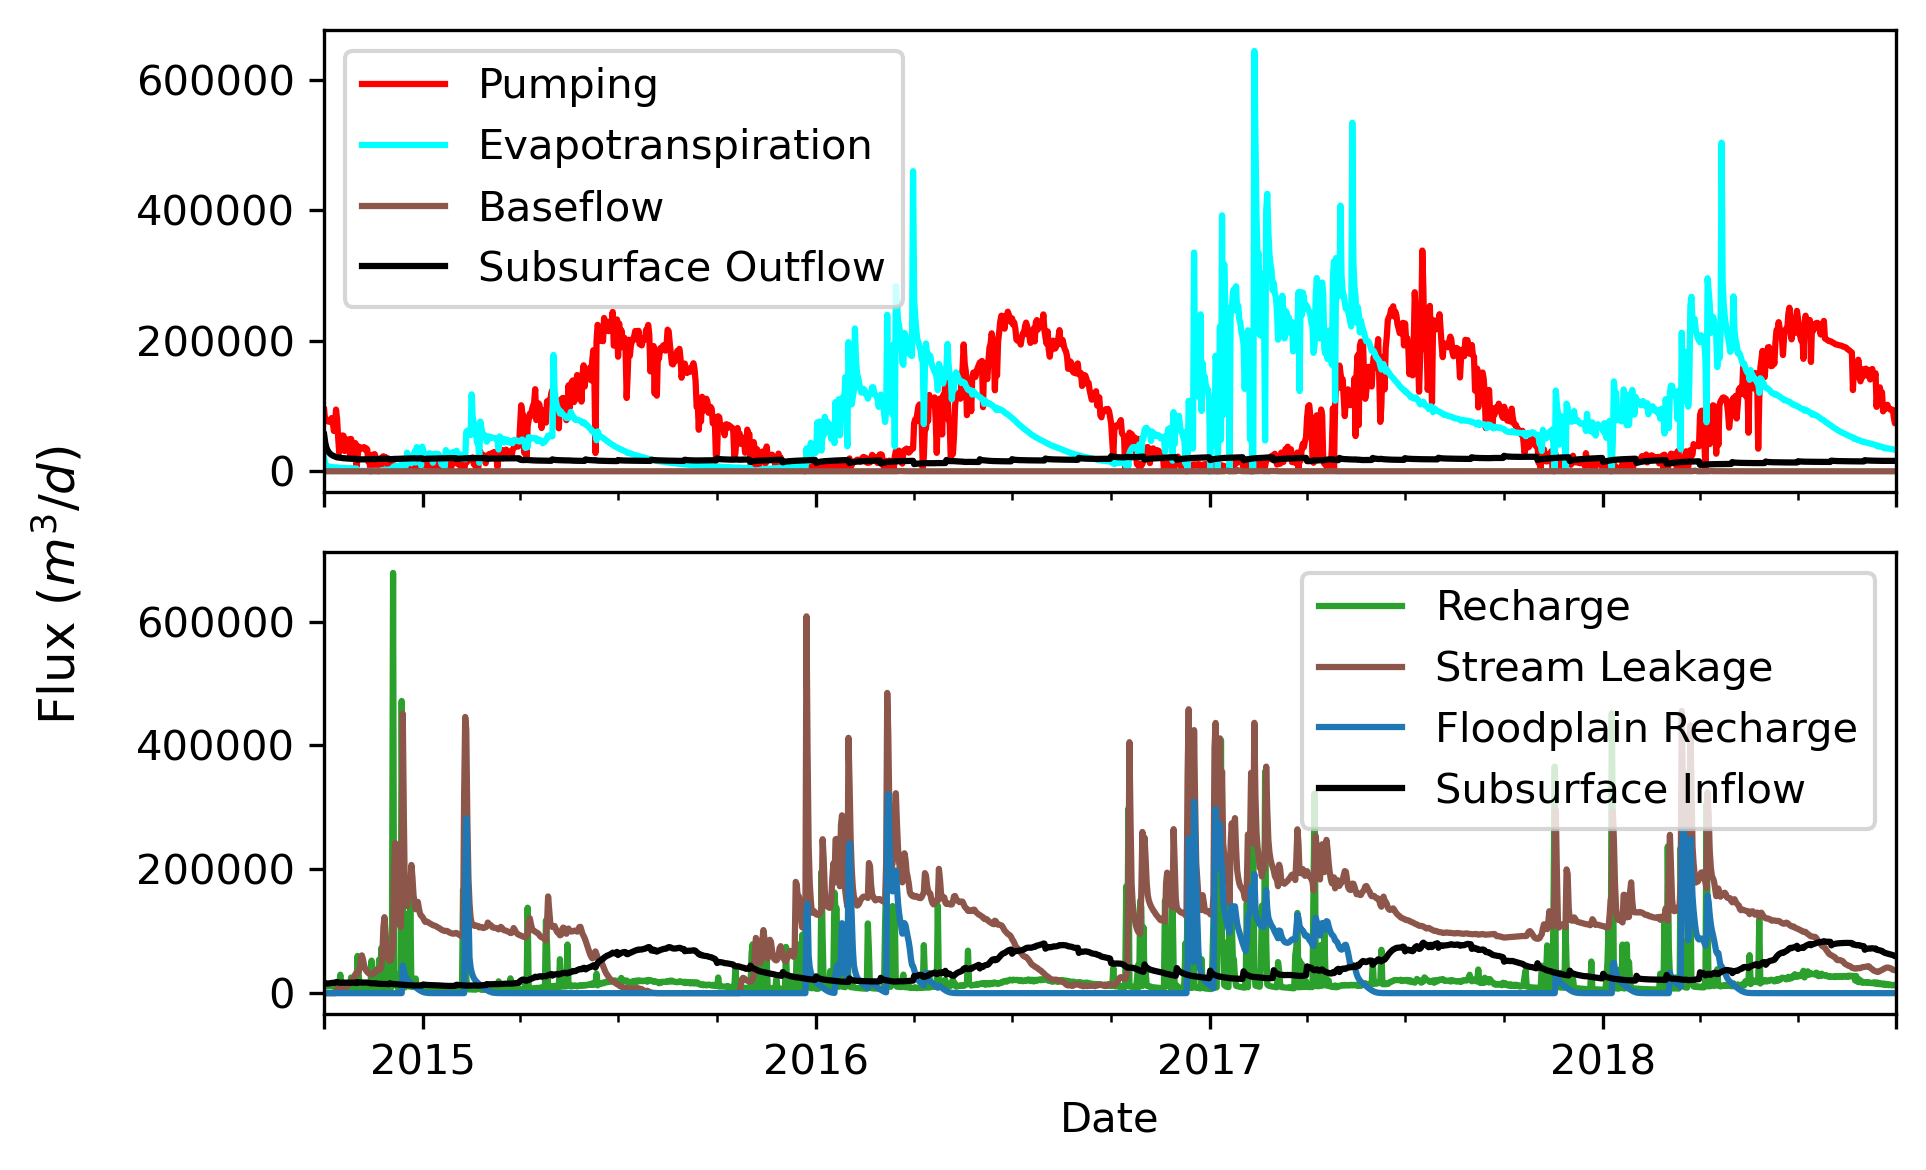

In [34]:
fig,ax= plt.subplots(2,1, sharex=True, figsize=(6.5, 4), dpi=300)
# wb.plot(y='PERCENT_ERROR', ax=ax[0])
wb.plot(y=out_cols, ax=ax[-2], legend=True, color=[color_dict[n] for n in out_cols], 
        label=[label_dict[n] for n in out_cols])
wb.plot(y=in_cols, ax=ax[-1], legend=True, color= [color_dict[n] for n in in_cols], 
        label=[label_dict[n] for n in in_cols])
plt.xlabel('Date')
fig.supylabel('Flux ($m^3/d$)')
fig.tight_layout()

In [35]:
sfr_dir = join(gwfm_dir, 'SFR_data')
# USGS presents flow in cfs (cubic feet per second)
inflow_in = pd.read_csv(join(sfr_dir,'MB_daily_flow_cfs_2010_2019.csv'), index_col = 'datetime', parse_dates = True)

# covnert flow from cubic feet per second to cubic meters per day
inflow_in['flow_cms'] = inflow_in.flow_cfs * (1/(3.28**3))
# filter out data between the stress period dates
inflow = inflow_in.loc[strt_date:end_date]

In [36]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000
# subset to model and reindex to match streamflow dates
rain_plt = rain_m['Fair Oaks'].loc[strt_date:end_date]
rain_plt = rain_plt.reindex(inflow.index)

In [54]:
rain_plt.resample('AS-Oct').sum()*12/0.3048

datetime
2014-10-01    15.157480
2015-10-01    17.161417
2016-10-01    36.992126
2017-10-01    22.964567
2018-10-01     0.000000
Freq: AS-OCT, Name: Fair Oaks, dtype: float64

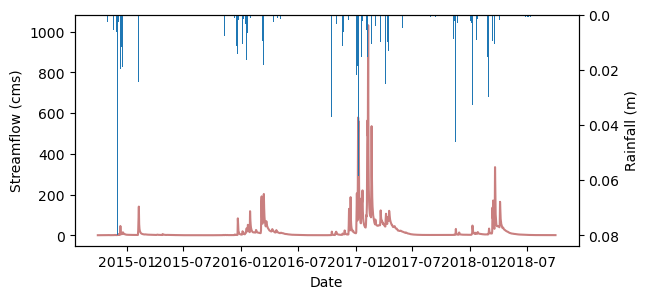

In [51]:
fig, ax = plt.subplots(figsize=(6.5,3))

dt = inflow.index.values
ax.plot(dt, inflow['flow_cms'], color='brown', alpha=0.6)
# Create second axes, in order to get the bars from the top you can multiply by -1
ax2 = ax.twinx()
ax2.bar(dt, -rain_plt, 0.9)
# Now need to fix the axis labels
max_pre = np.max(rain_plt)+0.01
y2_ticks = np.arange(0, max_pre, 0.02)
y2_ticklabels = [str(i) for i in y2_ticks]
ax2.set_yticks(-1 * y2_ticks)
ax2.set_yticklabels(y2_ticklabels)

ax2.set_ylabel('Rainfall (m)')
ax.set_ylabel('Streamflow (cms)')
ax.ticklabel_format(style='plain', axis='y') 
ax.set_xlabel('Date')

plt.show()


## Map spatial coverage of boundary conditions

In [38]:
gde_dir = join(uzf_dir,'shp_GDE_TFT')
GDE_cell = gpd.read_file(join(gde_dir,'Oneto_Denier','GDE_cell.shp'))



In [39]:

def spd_2_arr(sp_data, sp_col, dis):
    """Given the stress_period_data from flopy return the data in an array format
    """
    # convert pumping to array
    arr = np.zeros((dis.nper,dis.nrow,dis.ncol))
    for n in np.arange(0,dis.nper):
        data_n = sp_data[n]
        # only index array if there is data for a stress period
        if data_n is not None:
            arr[n, data_n.i, data_n.j] += data_n[sp_col]
    return(arr)


In [40]:
wel_arr = spd_2_arr(m.wel.stress_period_data, 'flux', m.dis)
wel_rate = wel_arr/(dis.delr[0]*dis.delc[0])
wel_row, wel_col = np.where(wel_rate.sum(axis=0)<0)

In [41]:

wel_ss = pd.DataFrame(m.wel.stress_period_data[0])
ag_grid_p = grid_p.set_index(['row','column']).loc[list(zip(wel_row+1, wel_col+1))].reset_index()
GDE_grid_p = grid_p.join(GDE_cell.drop(columns='geometry').set_index(['node','row','column']), 
                         on=['node','row','column'], how='inner')
# save dataframe of stream reach data
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_match.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index()

lak_grid = gpd.overlay(grid_match,lak_extent)


In [46]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor='brown',alpha=0.8,label='Boundary Groundwater Flow'),
    Patch(facecolor='aqua',alpha=0.8,label='GDE Evapotranspiration'),
    Patch(facecolor='red', edgecolor='r',alpha=0.6,label='Agricultural Pumping Wells'),
    # Patch(facecolor='red', edgecolor='r',alpha=0.6,label='Irrigated Lands'),
    Patch(facecolor='none', edgecolor='tab:blue',alpha=1,label='Reconnected Floodplain'),
#     Line2D([0], [0],color='tab:blue',label='Stream Segments', linewidth=4),
    Patch(facecolor='tab:blue', label='Stream Segments'),
                    ]


In [36]:
# deepest ag wells are about 180 m below ground which would be below model bottom
# and explains why some ag fields aren't plotted

In [45]:
# ag_grid_p

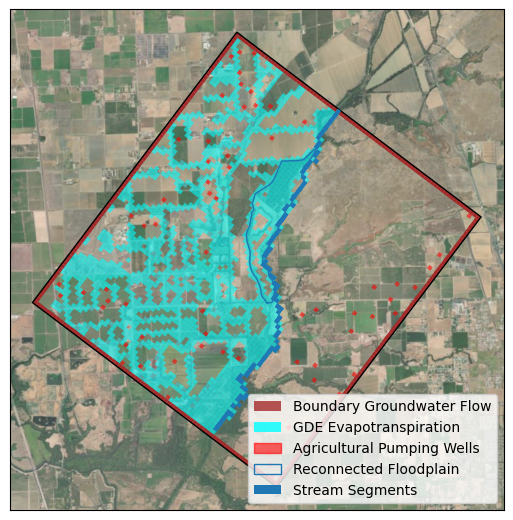

In [47]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
ag_grid_p.plot(ax=ax, color='red', alpha=0.6)
GDE_grid_p.plot(ax=ax, color='aqua', alpha=0.6)
bnd_cells.plot(ax=ax, color='brown')
m_domain.plot(ax=ax, color='none', edgecolor='black')

grid_sfr.plot(ax=ax, color='tab:blue')
lak_extent.plot(ax=ax,color='none',edgecolor='tab:blue')

ax.legend(handles=legend_elements, loc='lower right')

ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                crs = 'epsg:26910', alpha=0.8)

# drop axis labels for cleaner plot
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# TPROGs

In [52]:
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


<>:1: DeprecationWarning: invalid escape sequence '\D'
<>:1: DeprecationWarning: invalid escape sequence '\D'
C:\Users\andrewc\AppData\Local\Temp\ipykernel_19144\2785683405.py:1: DeprecationWarning: invalid escape sequence '\D'
  dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


In [44]:
import glob as glob
import tprogs_cleaning as tc
import pyvista as pv


In [45]:

tprogs_id = ''
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final' + tprogs_id+'/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')
# tprogs_files


In [46]:
t = 0
tprogs_line = np.loadtxt(tprogs_files[t])
# convert any negatives representing input data to same value
tprogs_arr = np.abs(np.reshape(tprogs_line, (320, 100,230)))


In [53]:
# bottom elevations array of tprogs
bot_elev = np.reshape(np.flip(np.arange(-80,80,0.5)), (320, 1,1))
bot_elev = np.repeat(np.repeat(bot_elev, 100, axis=1), 230, axis=2)


tprogs_info = [80, -80, 320]

tprogs_lay = tc.elev_to_tprogs_layers(elev=dem_data, tprogs_info=tprogs_info)


In [49]:
arr_dim = (320, 100, 230)

In [71]:
def mfarr2grid(arr):
    grid = pv.UniformGrid()
    # Set the grid dimensions: shape because we want to inject our values on the
    # I have to add 1 to each dimension to have it be built on the cells
    grid.dimensions = [101, 231, 321]
    # real origin, but incorrect because of no rotation
    # simple origin that allows easier data output cleaning
    grid.origin = (0, 0, 0) # bottom left corner of the dataset
    grid.spacing = (200,200,0.5)
    arr_in = np.moveaxis(arr,0,2).flatten(order='F').astype(int)
    grid.cell_data["facies"] = arr_in

    return(grid)


In [144]:
river_arr = np.zeros(arr_dim)
r_lay = tprogs_lay[grid_sfr.row_p.astype(int)-1, grid_sfr.column_p.astype(int)-1]
river_arr[r_lay-2, grid_sfr.row_p.astype(int)-1, grid_sfr.column_p.astype(int)-1] = 1
lak_lay = tprogs_lay[lak_grid.row_p.astype(int)-1, lak_grid.column_p.astype(int)-1]
river_arr[lak_lay-2, lak_grid.row_p.astype(int)-1, lak_grid.column_p.astype(int)-1] = 1

river_arr = np.flip(river_arr, axis=0)
river = mfarr2grid(river_arr)
river = river.threshold(value = [0.9, 1.1], scalars='facies') #, preference='cell'


In [79]:
# array to multiply others
local_cells = np.zeros(tprogs_arr.shape).astype(bool)
local_cells[:,grid_match.row_p-1, grid_match.column_p-1] = True

In [150]:
def pv_rot(mesh):
    mesh.rotate_z(90)
    mesh.rotate_x(10)
    # it seems that the tprogs data is somehow flipped when importing it into pyvista
    # because it requires an extra 180 degree rotation
    mesh.rotate_y(10)
#     mesh.rotate_y(200)

In [160]:

def grid_plt(grid, fig_nam, grid2=None):
    plotter = pv.Plotter(notebook=False, 
#                          lighting=None,
                         off_screen=True # if true then screenshots work
                        )
#     plotter.show_axes()
#     plotter.show_grid()
#     plotter.show_bounds()
    plotter.background_color='white'
    # show_egdes should be done locally but not regionally
    # but if I add lighting then I might not need edges
    mesh = plotter.add_mesh(grid, scalars="facies", cmap='viridis', lighting=True)
    pv_rot(mesh)
    # 50 x is good for regional, 20x is good for local
    plotter.set_scale(1, 1, 20)
    if grid2 is not None:
        mesh = plotter.add_mesh(grid2, color='black')
        pv_rot(mesh)
    plotter.show(screenshot=fig_nam + '.png')
    

In [163]:
t = 0
# 11 was a realization with good fit
for t in [11]:#[0,1,2]:
    tprogs_line = np.loadtxt(tprogs_files[t])
    # convert any negatives representing input data to same value
    tprogs_arr = np.abs(np.reshape(tprogs_line, (320, 100,230)))

    tprogs_in = tprogs_arr.copy()
    # crop data above land
    tprogs_in[bot_elev>dem_data] = 0
    # flip to keep orientation for pyvista
    tprogs_in = np.flip(tprogs_in, axis=0)
    # locally plot all facies
    tprogs_local = tprogs_in.copy()
    tprogs_local *= local_cells

    tprogs_local_grid = mfarr2grid(tprogs_local)
    tprogs_local_active = tprogs_local_grid.threshold(value = [0.9, 4.1], scalars='facies') #, preference='cell'

    tprogs_grid = mfarr2grid(tprogs_in)
    tprogs_active = tprogs_grid.threshold(value = [0.9, 4.1], scalars='facies') #, preference='cell'
    grid_plt(tprogs_local_active, join(fig_dir,'tprogs_local_facies_r'+str(t).zfill(3)), river)
    grid_plt(tprogs_active, join(fig_dir,'tprogs_facies_r'+str(t).zfill(3)), river)


In [161]:
grid_plt(tprogs_local_active, join(fig_dir,'tprogs_local_facies_r'+str(t).zfill(3)), river)
grid_plt(tprogs_active, join(fig_dir,'tprogs_facies_r'+str(t).zfill(3)), river)

# on the local scale we can start to distinguish paths but it isn't very clear still